Case 4
Fabian Brock
i6248959

# Payoff of tilted call option (with risk free rate)
payoff $= max(S_T - K, 0)$ which can be written as $(S_T - K) * 1_{\{S_T > K\}}$
$\ $
Value of call option under risk neutral measure Q is the discounted expectation of the payoff at maturity:
$\ $
$C(S,t) = e^{-r(T-t)}E^Q[(S_T - K) * 1_{\{S_T > K\}}]$
$\ $
Use fourier transofrm w.r.t log price $x = log(S_T)$
$\ $
$\hat{c}(u) = \int_{-\infty}^{\infty} e^{iux} (e^x - K) * 1_{\{S_T > K\}} dx$
$\ $
Multiply by damping factor alpha
$\ $
$\hat{c_a}(u) = \int_{-\infty}^{\infty} e^{iux} (e^x - K) * 1_{\{S_T > K\}} e^{-\alpha x} dx$
$\ $
Switch order of integration
$\ $
$\hat{c_a}(u) = \int_{log(K)}^{\infty} e^{iux-\alpha x} * (e^x - K) dx $
$\ $
So the characterstic function becomes:
$\ $
$\phi_T(u) = exp(iu(log(S_0) + (r - \frac{\sigma^2}{2})T) - \frac{\sigma^2}{2}u^2T)$
$\ $
The price of the call by inverse fourier transform at $x = log(K)$
$\ $
$C(S,t) = \frac{e^{-ax}}{\pi} \int_{-\infty}^{\infty} e^{iux} \phi_T(u) \hat{c_a}(u) du$


In [1]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.linalg import inv
import time
from utils import ftint2

In [2]:
# params
S0 = 100
K = 100
T = 1
sig = 0.16
r = 0.00 # Risk-free rate

In [3]:
# https://www.econstor.eu/bitstream/10419/25030/1/496002368.PDF I used help from here
# char funciton of log price
def charfct(v, T, r, sigma, S0):
    mu = np.log(S0) + (r - 0.5 * sigma ** 2) * T
    var = sigma ** 2 * T
    return np.exp(1j * v * mu - 0.5 * v ** 2 * var)

# psi after interchange of integrals
def psi_T(v, T, r, alpha, char_func):
    numerator = np.exp(-r * T) * char_func(v - (alpha + 1) * 1j, T, r, sigma, S0)
    denominator = alpha ** 2 + alpha - v ** 2 + 1j * (2 * alpha + 1) * v
    return numerator / denominator

# fourier inversion
def option_price_FT(k, T, r, alpha, sigma, S0):
    # integrate inverse fourier transform
    integrand = lambda v: np.real(np.exp(-1j * v * k) * psi_T(v, T, r, alpha, charfct))
    integral = integrate.quad(integrand, 0, np.inf)[0]
    return np.exp(-alpha * k) * integral / np.pi

# Parameters
S0 = 100  # Initial stock price
K = 100   # Strike price
T = 1     # Time to maturity
r = 0.01  # Risk-free rate
sigma = 0.16   # Volatility
alpha = sigma + 0.1   # Damping factor

# Calculate the option price
k = np.log(K)
option_price = option_price_FT(k, T, r, alpha, sigma, S0)
print("Option Price:", option_price)


Option Price: 6.854421357673323


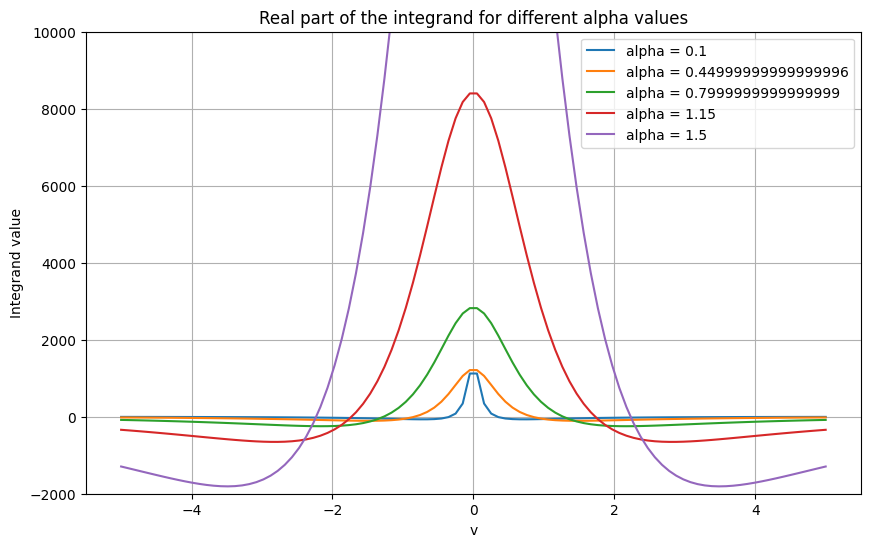

In [4]:
# integrand
def integrand(v, k, T, r, alpha, sigma, S0):
    return np.real(np.exp(-1j * v * k) * psi_T(v, T, r, alpha, charfct))

# Range of alpha values
alpha_values = np.linspace(0.1, 1.5, 5)

# Range of v values for integration
v_values = np.linspace(-5, 5, 100)

plt.figure(figsize=(10, 6))
plt.ylim(-2000,10000)

for alpha in alpha_values:
    integrand_values = [integrand(v, k, T, r, alpha, sigma, S0) for v in v_values]
    plt.plot(v_values, integrand_values, label=f'alpha = {alpha}')

plt.title('Real part of the integrand for different alpha values')
plt.xlabel('v')
plt.ylabel('Integrand value')
plt.legend()
plt.grid(True)
plt.show()


## Is the "tilting" trick necessary for puts
Yes, I think for puts it is still necessary, since the function is still not directly integrable (in the fourier sense). Since the payoff is bounded by K, which does not decay to 0, the integrand will not converge, so the tilting trick is necessary to force the integral to converge.
## Tilting for UL contract
Intuitively I think the tilting trick can not be applied to the UL payoff directly. But I have no mathematical explanation. Maybe something because it is unbounded above the guarantee, but lower bounded by the guarantee, finding an alpha value might be difficult?


# Implicit Finite Difference Method

In [6]:
# init params
S0 = 100  # initial stock price
K = 100  # guarantee
r = 0.01
sigma = 0.15
T = 10  # time to maturity

Smax = 200  # maximum stock price (it can go higher than this, but 200 already gives a good value)
Smin = 0  # minimum stock price
m = 200  # number of stock parititions
n = 200  # timesteps

# increments
delta_T = T / n
delta_S = (Smax - Smin) / m

# create coeff matrix
def get_coefficient_matrix(m, delta_T, delta_S, sigma, r, q=0):
    # init arrays
    a_ls = np.zeros(m + 1)
    b_ls = np.zeros(m + 1)
    c_ls = np.zeros(m + 1)

    # populate coeffs
    for j in range(m + 1):
        a_ls[j] = ((r - q) / 2 * j * delta_T) - (sigma ** 2 * j ** 2 * delta_T / 2)
        b_ls[j] = 1 + sigma ** 2 * j ** 2 * delta_T + r * delta_T
        c_ls[j] = -((r - q) / 2 * j * delta_T) - (sigma ** 2 * j ** 2 * delta_T / 2)

    # crate matrix
    coeff_matrix = np.zeros((m - 1, m - 1))
    # set up boundaries
    coeff_matrix[0, 0] = b_ls[m - 1]
    coeff_matrix[0, 1] = a_ls[m - 1]
    coeff_matrix[m - 2, m - 3] = c_ls[1]
    coeff_matrix[m - 2, m - 2] = b_ls[1]

    # fill in points
    for j in range(1, m - 2):
        coeff_matrix[j, j - 1] = c_ls[m - j - 1]
        coeff_matrix[j, j] = b_ls[m - j - 1]
        coeff_matrix[j, j + 1] = a_ls[m - j - 1]
    return coeff_matrix, c_ls[m - 1], a_ls[1]

# payoff
def get_payoff(price, K):
    # get guarantee
    return max(price, K)

# backward induction for fd
def backward_induction(m, n, Smin, delta_S, Smax, coeff_matrix, c_m_1, a1, K):
    # matrix to store option values
    f_matrix = np.zeros((m + 1, n + 1))
    # sboundaries
    for i in range(n):
        f_matrix[0, i] = get_payoff(Smax, K)
        f_matrix[m, i] = get_payoff(Smin, K)

    # payoff at maturity
    for j in range(m + 1):
        f_matrix[m - j, n] = get_payoff(Smin + j * delta_S, K)

    # backward induction
    for i in range(n - 1, -1, -1):
        known_f_ls = f_matrix[1:m, i + 1]
        known_f_ls[0] -= c_m_1 * f_matrix[0, i]
        known_f_ls[m - 2] -= a1 * f_matrix[m, i]
        unknown_f_ls = inv(coeff_matrix) @ known_f_ls
        # stay > 0
        for j in range(1, m):
            f_matrix[j, i] = max(unknown_f_ls[j - 1], 0)

    # get price at time 0
    index_j = int(m * (S0 - Smin) / (Smax - Smin))
    target_j = m - index_j
    option_value = f_matrix[target_j, 0]
    return option_value

# timing out of interest
start_time = time.time()

# gen coeff matrix
coeff_matrix, c_m_1, a1 = get_coefficient_matrix(m, delta_T, delta_S, sigma, r)

# calc value
option_price = backward_induction(m, n, Smin, delta_S, Smax, coeff_matrix, c_m_1, a1, K)

end_time = time.time()

# Print out the results including the execution time
print(f"UL Contract Value = {option_price:.4f}")
print(f"Computation time: {end_time - start_time:.2f} seconds")


UL Contract Value = 113.4520
Computation time: 8.14 seconds


In [7]:
def IFD(S0, K, r, sigma, T, Smax, Smin, m, n):
    # increments
    delta_T = T / n
    delta_S = (Smax - Smin) / m

    coeff_matrix, c_m_1, a1 = get_coefficient_matrix(m, delta_T, delta_S, sigma, r)

    # calc value
    return backward_induction(m, n, Smin, delta_S, Smax, coeff_matrix, c_m_1, a1, K)

In [8]:
S0 = 100  # initial stock price
K = 100  # guarantee
r = 0.01
sigma = 0.15
T = 10  # time to maturity

Smax = 200  # maximum stock price (it can go higher than this, but 200 already gives a good value)
Smin = 0  # minimum stock price
m = 100  # number of stock parititions
n = 100  # timesteps
IFD(S0, K, r, sigma, T, Smax, Smin, m, n)

113.43646099731099

## Binomial Tree "Top" and "Bottom"
The binomial tree does not need "top" and "bottom" values since the price can only move by predetermined up or down factors in the given time steps. Additionally I think the binomial tree naturally converges with higher number of iterations, whereas the FD method needs bounds to actually converge to the correct value. I think this is because FD methods try to solve continuous equations (black scholes) over a discrete space, whereas binomial trees are just simulations.

In [10]:
# using M*N = 1_000_000 is too much, takes too long, so i will use 10_000
Ms = np.array([10, 100, 500, 1000, 2000, 3333, 10000])
Ns = 10_000 // Ms

def zipcalc(Ms, Ns, iters):
    prices = []
    for m, n in zip(Ms, Ns):
        price = 0

        for i in range(iters):
            p = IFD(S0, K, r, sigma, T, Smax, Smin, m, n)
            price += p
        prices.append(price / iters)
        print(f"M={m}, N={n}, price = {price}")


    return prices
prices = zipcalc(Ms, Ns, 1)

M=10, N=1000, price = 113.07388265698006
M=100, N=100, price = 113.43646099731099
M=500, N=20, price = 113.33889364283769
M=1000, N=10, price = 113.21363535255
M=2000, N=5, price = 112.96692894289467
M=3333, N=3, price = 112.62702234917599
M=10000, N=1, price = 111.21255723501388


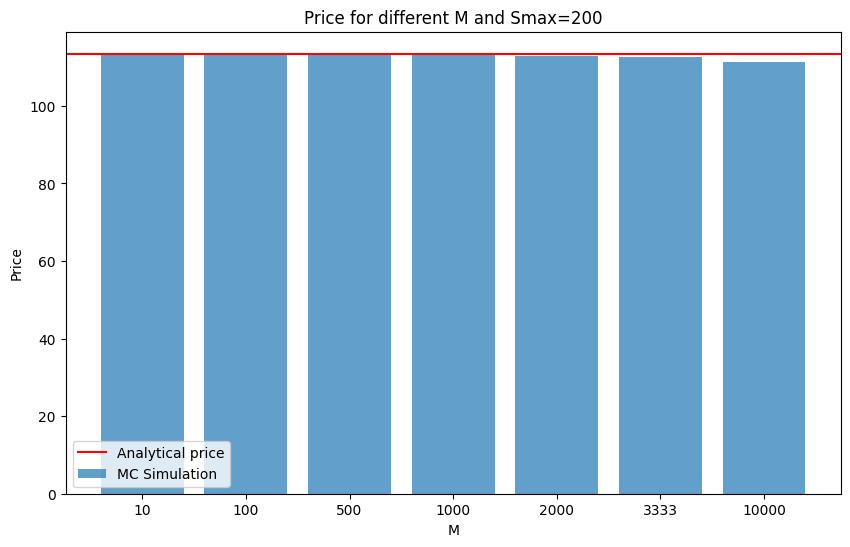

In [11]:
plt.figure(figsize=(10, 6))
bar_positions = range(len(Ms))  # fixed positions
plt.bar(bar_positions, prices, align='center', alpha=0.7, label='MC Simulation')
plt.axhline(y=113.481, color='r', linestyle='-', label='Analytical price')
plt.xticks(bar_positions, Ms)
plt.xlabel('M')
plt.ylabel('Price')
plt.title('Price for different M and Smax=200')
plt.legend()
plt.show()


## Convergence behaviour for step sizes
Here, Clearly it is better to have higher N than M, i.e. smaller $\Delta t$, however one must not increase N too far, since it seems that the solution quality also deteriorates slowly when M becomes too small i.e. $\Delta x$ becomes too large.
So when limited by a fixed number one should decrease $\Delta t$ as much as possible (increase M), but not too much. The sweet spot for a limit of M*N = 10_000 seems to be around M=100, N=100.


M=10, N=1000, price = 100.0
M=100, N=100, price = 101.54645355895975
M=500, N=20, price = 110.74341668735887
M=1000, N=10, price = 113.23495163064476
M=2000, N=5, price = 113.0163723948894
M=3333, N=3, price = 112.46177066092679
M=10000, N=1, price = 111.36104851508654


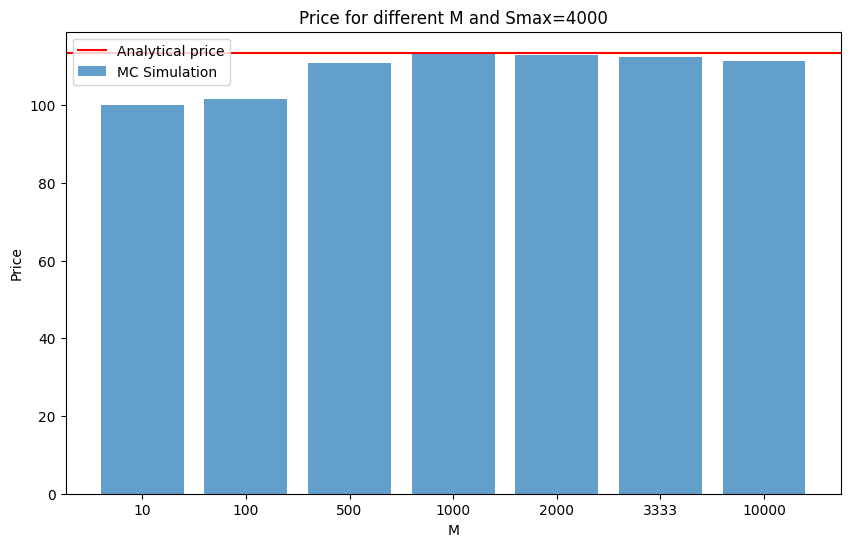

In [12]:
Smax = 4000
prices = zipcalc(Ms, Ns, 1)
plt.figure(figsize=(10, 6))
bar_positions = range(len(Ms))  # fixed positions
plt.bar(bar_positions, prices, align='center', alpha=0.7, label='MC Simulation')
plt.axhline(y=113.481, color='r', linestyle='-', label='Analytical price')
plt.xticks(bar_positions, Ms)
plt.xlabel('M')
plt.ylabel('Price')
plt.title('Price for different M and Smax=4000')
plt.legend()
plt.show()

Here, Clearly it is better to have higher M than N, i.e. smaller $\Delta x$, however one must not increase M too far, since it seems that the solution quality also deteriorates slowly when N becomes too small i.e. $\Delta t$ becomes too large.
So when limited by a fixed number one should decrease $\Delta x$ as much as possible (increase M), but not too much. The sweet spot for a limit of M*N = 10_000 seems to be around M=1000, N=10.

## Convergence behaviour depends on M,N and the Boundaries
This makes sense, since one can imagine a 2D grid, with boundaries, if the granularity along one axis is too small, then the values will not be good, for decent boundaries, the optimal will lie close to a perfect square e.g. M = N = 100, however if the boundaries are chosen poorly (or differently maybe for more complex options in the future) the optimal allocation of M and N might vary. So in general if the matrix is a square (the boundaries exhibit a square like shape) the optimal allocation will be a square, otherwise it will be skewed in one or the other direction.